In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchinfo import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from model import UNet
from datasets.dataset import LandcoverDataset

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [3]:
TRAIN_IMG_DIR = "data/landcover/train/images/"
TRAIN_MASK_DIR = "data/landcover/train/masks/"

VAL_IMG_DIR = "data/landcover/val/images/"
VAL_MASK_DIR = "data/landcover/val/masks/"

TEST_IMG_DIR = "data/landcover/test/images/"
TEST_MASK_DIR = "data/landcover/test/masks/"

In [4]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

criterion = nn.CrossEntropyLoss()

In [5]:
train_transforms = A.Compose(
    [
        A.Resize(height=64, width=64),
        A.Rotate(limit=35, p=1.0),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=64, width=64),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [6]:
train_dataset = LandcoverDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transforms,
)

val_dataset = LandcoverDataset(
    image_dir=VAL_IMG_DIR,
    mask_dir=VAL_MASK_DIR,
    transform=val_transforms,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [7]:
masks_to_labels = {
    0: "Other",
    1: "Buildings",
    2: "Woodlands",
    3: "Water",
    4: "Roads",
}

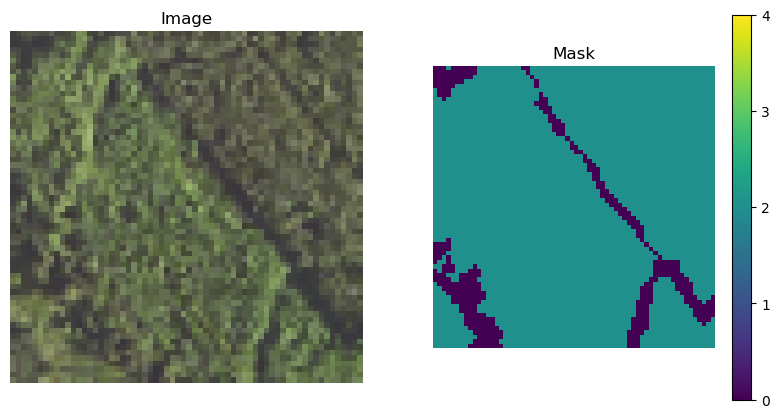

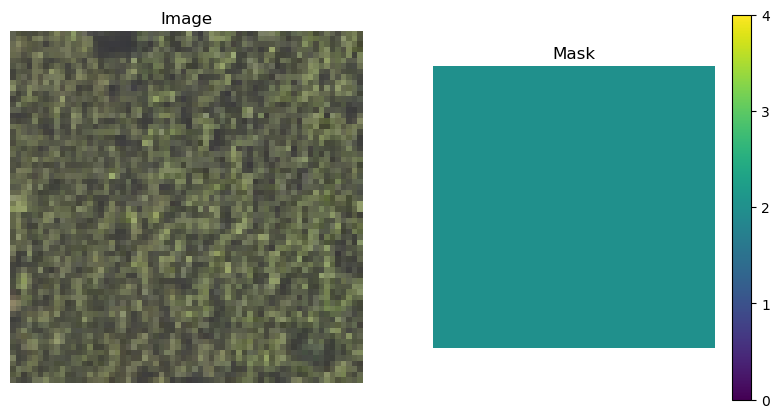

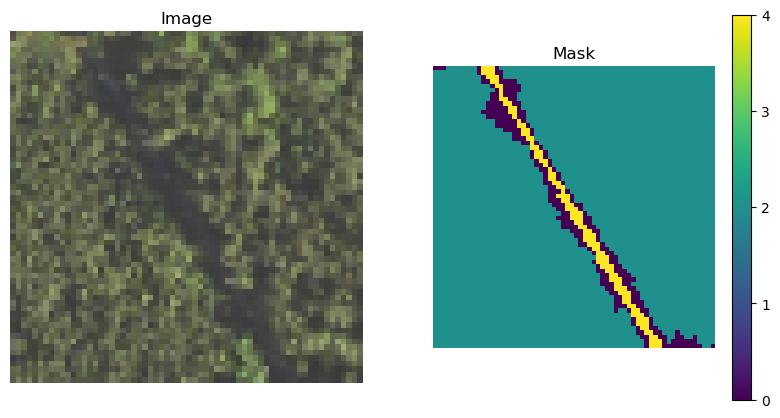

In [8]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(3):
    image, mask = train_dataset[i]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(np.transpose(image, (1, 2, 0)))
    axs[0].set_title("Image")

    mask = mask.squeeze()

    m = axs[1].imshow(mask, vmin=0, vmax=4)
    axs[1].set_title("Mask")
    plt.colorbar(m, ax=axs[1], ticks=[0, 1, 2, 3, 4])

    for ax in axs:
        ax.axis("off")

    plt.show()

In [11]:
model = UNet(
    in_channels=3,
    n_classes=5,
    features=[64, 128, 256],
)

summary(model, input_size=(16, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 5, 64, 64]           --
├─ModuleList: 1-5                        --                        (recursive)
│    └─DoubleConv: 2-1                   [16, 64, 64, 64]          --
│    │    └─Sequential: 3-1              [16, 64, 64, 64]          38,848
├─MaxPool2d: 1-2                         [16, 64, 32, 32]          --
├─ModuleList: 1-5                        --                        (recursive)
│    └─DoubleConv: 2-2                   [16, 128, 32, 32]         --
│    │    └─Sequential: 3-2              [16, 128, 32, 32]         221,696
├─MaxPool2d: 1-4                         [16, 128, 16, 16]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─DoubleConv: 2-3                   [16, 256, 16, 16]         --
│    │    └─Sequential: 3-3              [16, 256, 16, 16]         885,760
├─MaxPool2d: 1-6                         [16

In [9]:
model = UNet(
    in_channels=3,
    n_classes=5,
    features=[64, 128, 256],
)

model.load_state_dict(torch.load("trained_models/model1.pth"))
model.to(DEVICE)

UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e

In [10]:
LEARNING_RATE = 1e-4

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [11]:
NUM_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print('\n----------------------------------')
    print(f'EPOCH: {epoch + 1}/{NUM_EPOCHS}')

    model.train()

    train_loss = 0.0
    for batch_idx, (image, target_mask) in enumerate(train_dataloader):
        print(f'Batch: {batch_idx + 1}/{len(train_dataloader)}', end="\r")
        image = image.to(DEVICE)
        target_mask = target_mask.float().to(device=DEVICE)

        # forward
        logits = model(image)

        target_mask = target_mask.long()
        target_mask = target_mask.squeeze(1)

        loss = criterion(logits, target_mask)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0
    num_correct = 0
    num_pixels = 0
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            num_correct += (preds == y.squeeze()).sum()
            num_pixels += torch.numel(preds)

            y = y.long()
            y = y.squeeze(1)

            loss = criterion(logits, y)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), "trained_models/model2.pth")

    print(
        f"Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {num_correct / num_pixels}"
    )


----------------------------------
EPOCH: 1/10
Train Loss: 0.24834511013945523, Validation Loss: 0.2849901988640551, Validation Accuracy: 0.8973004221916199

----------------------------------
EPOCH: 2/10
Train Loss: 0.24124240364081648, Validation Loss: 0.2815137060189789, Validation Accuracy: 0.8964916467666626

----------------------------------
EPOCH: 3/10
Train Loss: 0.2417468797887933, Validation Loss: 0.2549022554981807, Validation Accuracy: 0.9063648581504822

----------------------------------
EPOCH: 4/10
Train Loss: 0.23634098693263753, Validation Loss: 0.2692280529944365, Validation Accuracy: 0.9009857773780823

----------------------------------
EPOCH: 5/10
Train Loss: 0.23415717358648652, Validation Loss: 0.2336687743971663, Validation Accuracy: 0.914351761341095

----------------------------------
EPOCH: 6/10
Train Loss: 0.22605343468161979, Validation Loss: 0.2406812758793023, Validation Accuracy: 0.911791205406189

----------------------------------
EPOCH: 7/10
Train L

Accuracy: 0.99853515625


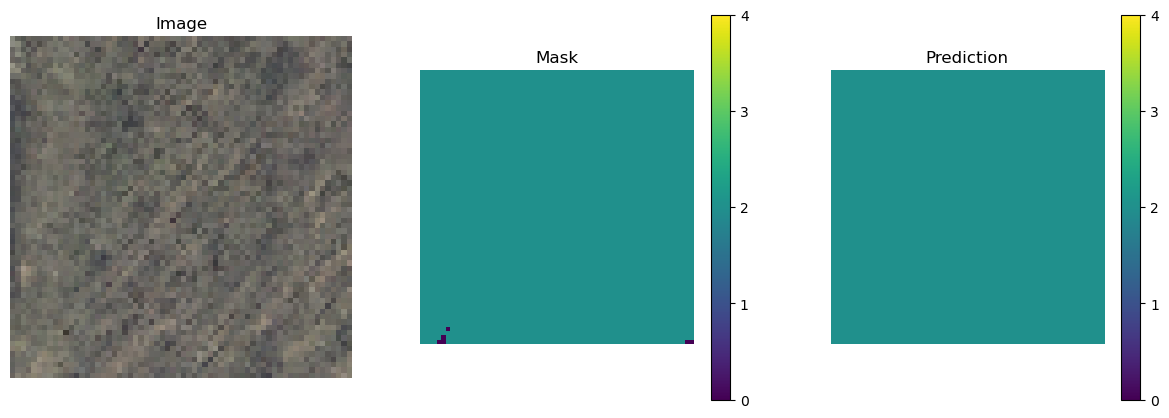

Accuracy: 0.98291015625


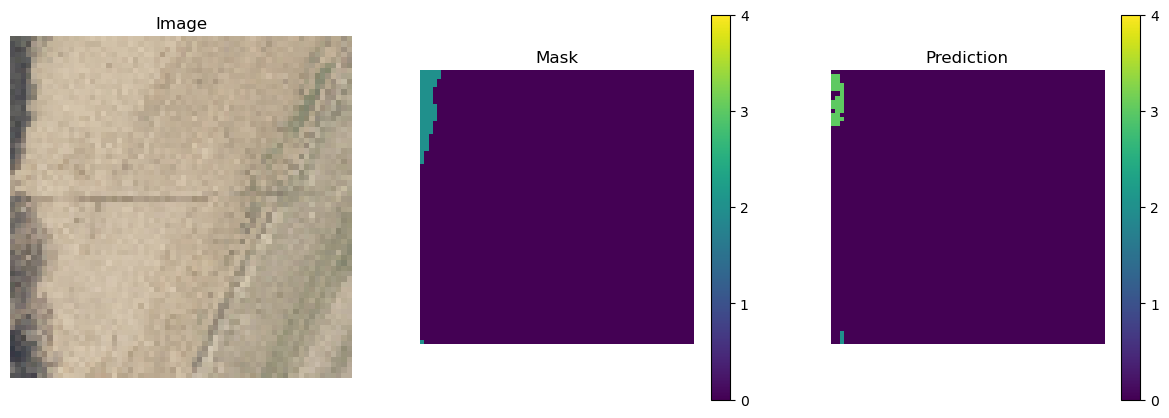

Accuracy: 1.0


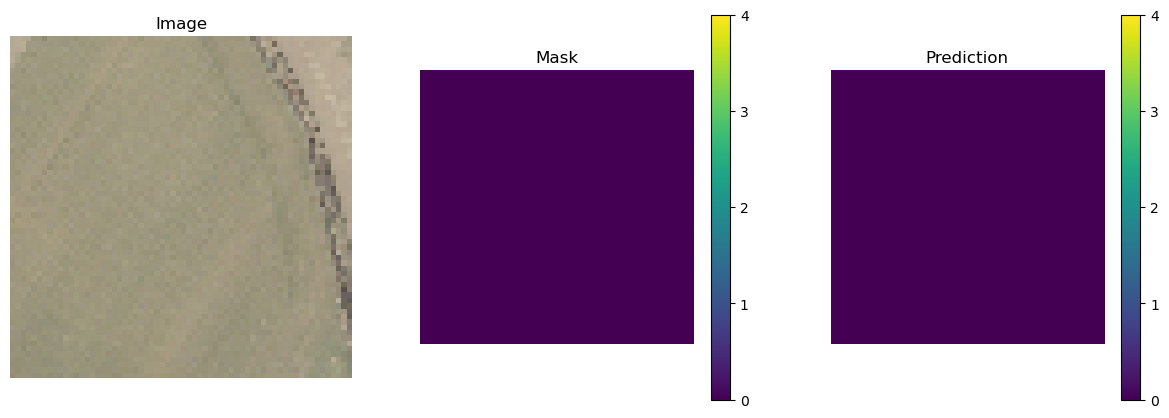

Accuracy: 0.93310546875


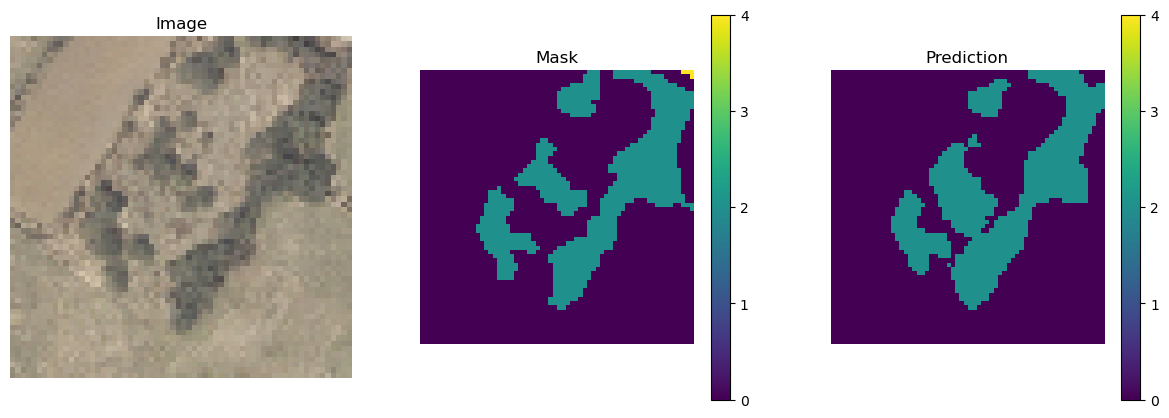

Accuracy: 0.980224609375


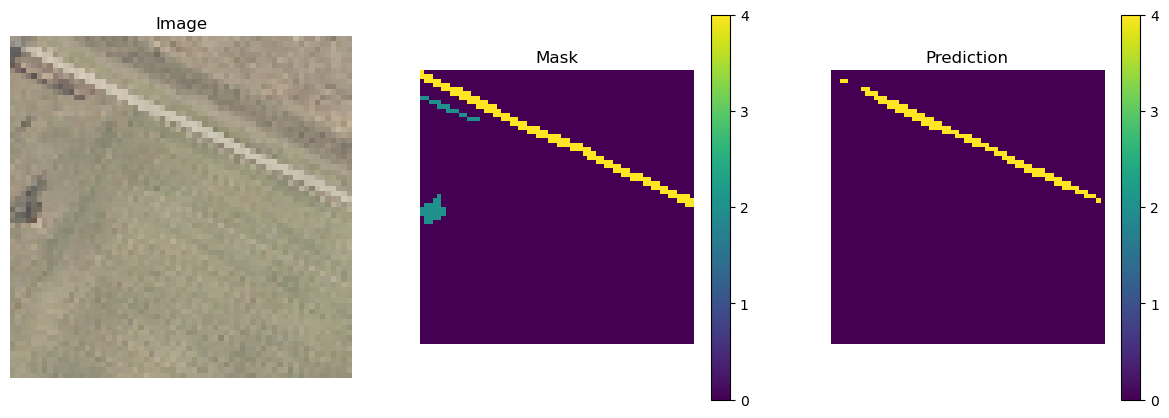

In [12]:
model.eval()
for i in range(5):
    image, mask = val_dataset[i + 200]
    image = image.unsqueeze(0)
    with torch.no_grad():
        image = image.to(DEVICE)
        logits = model(image)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        print(f"Accuracy: {(mask == preds.cpu()).sum() / torch.numel(mask)}")

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(np.transpose(image.squeeze(0).cpu(), (1, 2, 0)))
    axs[0].set_title("Image")

    mask = mask.squeeze()

    m = axs[1].imshow(mask, vmin=0, vmax=4)
    axs[1].set_title("Mask")
    plt.colorbar(m, ax=axs[1], ticks=[0, 1, 2, 3, 4])

    p = axs[2].imshow(preds.cpu().squeeze(0), vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    plt.colorbar(p, ax=axs[2], ticks=[0, 1, 2, 3, 4])

    for ax in axs:
        ax.axis("off")

    plt.show()

In [13]:
test_dataset = LandcoverDataset(
    image_dir=TEST_IMG_DIR,
    mask_dir=TEST_MASK_DIR,
    transform=val_transforms,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

model.eval()

num_correct = 0
num_pixels = 0

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        num_correct += (preds == y.squeeze()).sum()
        num_pixels += torch.numel(preds)


print(
    f"Test Accuracy: {num_correct / num_pixels}"
)

Test Accuracy: 0.9245027303695679
